# Сборный проект - 2 (Стартап продуктов питания)

**Описание проекта:**

Дизайнерский отдел предложил поменять шрифты во всём приложении, что бы улучшить клиентский опыт и обратились к менеджерам. Что бы внедрять такие резкое решение на совещании было принято предложение о проведении A/B-теста, на основе результатов которого будет принято решение о внедрении новых шрифтов. Было также предложено провести тест с более высокой точностью и аккуратностью результатов. Поэтому решили взять 2 контрольные группы и A/B-тест стал А/A/B-тестом.

**Задание**: Изучить поведение пользователей мобильного приложения и выстроить воронку продаж. Далее исследовать результаты A/A/B-эксперимента.

**Цели исследования:**
1) Изучить данные логов, связанных с событиями (event);

2) Изучить воронку событий;

3) Проанализировать результаты A/A/B - эксперимента.

Описание данных:

Дан 1 датасет - logs_exp.csv, который содержит логи событий пользователей с его айди, типом события, группой и временем:

**Структура hypothesis.csv :**

* EventName — название события;

* DeviceIDHash — уникальный идентификатор пользователя;

* EventTimestamp — время события;

* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**Проект состоит из 4 частей:**

1) Выгрузка и изучение общей информации о данных;

2) Предобработка и подготовка к анализу;

3) Изучить и проверить данные логов;

4) Изучить воронку событий;

5) Провести A/A/B-тест и изучить его результаты;

6) Общий вывод.

## -  Выгрузим файл с данными и изучим общую информацию

In [ ]:
import pandas as pd
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math as mth
import plotly.express as px

In [ ]:
#Запишем данные выгрызки логов в df и выведем на экран
df=pd.read_csv('logs_exp.csv',sep='\t')
display(df)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [ ]:
#Изучим общую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [ ]:
shape_1=df.shape[0]
quantity_user_1=df['DeviceIDHash'].nunique()
print('Количество строк в таблице:',shape_1)
print('Количество пользователй в таблице:',quantity_user_1)

Количество строк в таблице: 244126
Количество пользователй в таблице: 7551


**Выгрузил и вывел данные на экран. Изучил общую информацию о датасете.**

**------------------------------------------------------------------------------------------------------------------------------------------------**

## - Подготовим данные к анализу

In [ ]:
# переименуем столбцы
df.columns=['event','user','time','exp_id']
df.head()

,event,user,time,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [ ]:
df.isna().sum()

event     0
user      0
time      0
exp_id    0
dtype: int64

Пропусков не обнаружено

In [ ]:
print('Количество дубликатов:',df[df.duplicated()].sort_values(by='user').shape[0])
display(df[df.duplicated()].sort_values(by='user'))

Количество дубликатов: 413


,event,user,time,exp_id
130558,MainScreenAppear,33176906322804559,1564933075,248
130995,OffersScreenAppear,33176906322804559,1564933763,248
104108,CartScreenAppear,34565258828294726,1564857221,248
159302,PaymentScreenSuccessful,54903596035630984,1565011672,248
176813,PaymentScreenSuccessful,77364241990273403,1565044732,246
...,...,...,...,...
56851,PaymentScreenSuccessful,9110248565804959041,1564750074,248
200171,PaymentScreenSuccessful,9160437016685643194,1565104416,247
199849,CartScreenAppear,9160437016685643194,1565103970,247
204831,PaymentScreenSuccessful,9187990861085277398,1565110888,247


Как видно на лицо дубликаты - удалим их

In [ ]:
pd.options.mode.chained_assignment = None

Судя по всему время дано в секундах которые прошло с начала 1970 года.

Добавим столбцы с временем и датой.

In [ ]:
df['time']=pd.to_datetime(df.loc[:,'time'],unit='s')
df['date']=pd.DatetimeIndex(df['time']).date
display(df.head())
display(df.info())

,event,user,time,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   event   244126 non-null  object        
 1   user    244126 non-null  int64         
 2   time    244126 non-null  datetime64[ns]
 3   exp_id  244126 non-null  int64         
 4   date    244126 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


None

Добавим более удобные названия для групп

In [ ]:
def group(exp_id):
    if exp_id==246:
        return 'A1'
    if exp_id==247:
        return 'A2'
    if exp_id==248:
        return 'B'

df['group']=df['exp_id'].apply(group)
df

,event,user,time,exp_id,date,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,A1
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,A1
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,B
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,B
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,B
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,A2
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,A1
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,A1
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,A1


In [ ]:
user_intersection=df.pivot_table(index='user',values='group',aggfunc='nunique')
user_intersection.query('group>1')

,group
user,


Как видно нет пользователей, что находились бы больше чем в одной группе

**Вывод:**

**Переименовал столбцы: событие - event, id пользователя в user, время - time, группа - exp_id. Проверил и не обнаружил пропусков. При проверки на дубликаты - их обнаружилось 413 - удалил дубликаты. Проверил группы на пересечению пользователей - не обнаруженно. Время изначально дано в секундах прошедших с начала 1970 года - перевел их более привычное время с датой, а также добавил отдельный столбец для даты. Добавил в датасет более удобный названия для групп. Для контрольных групп: 246 - A1, 247 - A2. Для экспериментальной группы: 248 - B.**

Проверили данные на наличие пропусков и дубликатов.  Привоелт даты к нужному формату, а также проверили пересечение пользователей между группами - предобработка проведена .
</div>

**------------------------------------------------------------------------------------------------------------------------------------------------**

## Изучение и проверка данных

In [ ]:
print('В логе "logs_exp.csv" после предобработки:',df.shape[0],'событий.')
print()
print('В логе "logs_exp.csv":',df['user'].nunique(),'пользователей.')

В логе "/datasets/logs_exp.csv" после предобработки: 244126 событий.

В логе "/datasets/logs_exp.csv": 7551 пользователей.


,events_number
user,
6304868067479728361,2308
197027893265565660,2003
4623191541214045580,1771
6932517045703054087,1448
1754140665440434215,1222
3337471580007169353,1186
7738058666231999878,893
1055544042902443290,854
4713748699910253089,824


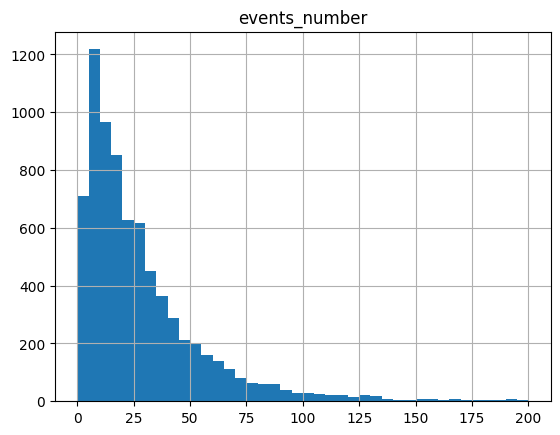

In [ ]:
number_of_events=df.pivot_table(index='user',values='time',aggfunc='count').sort_values(by='time',ascending=False)
number_of_events.columns=['events_number']
display(number_of_events.head(20))
number_of_events.hist(bins=40, range=(0,200));

In [ ]:
print('На 1 пользователя в среднем приходится',round(df.shape[0]/df['user'].nunique()),'событий, но если быть точнее то',round(df.shape[0]/df['user'].nunique(),4),'событий')
print()
print('Медианное количество событий на 1 пользователя:',round(number_of_events.median()[0]))

На 1 пользователя в среднем приходится 32 событий, но если быть точнее то 32.3303 событий

Медианное количество событий на 1 пользователя: 20


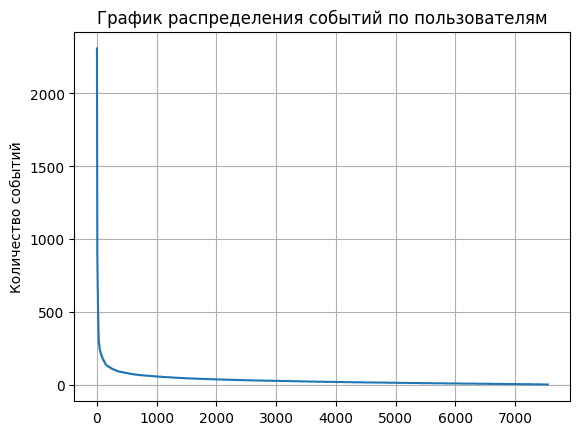

In [ ]:
number_of_events.reset_index(drop=True).plot()
legend = plt.legend()
legend.remove()
plt.ylabel('Количество событий')
plt.ticklabel_format(style='plain')
plt.title('График распределения событий по пользователям')
plt.grid()

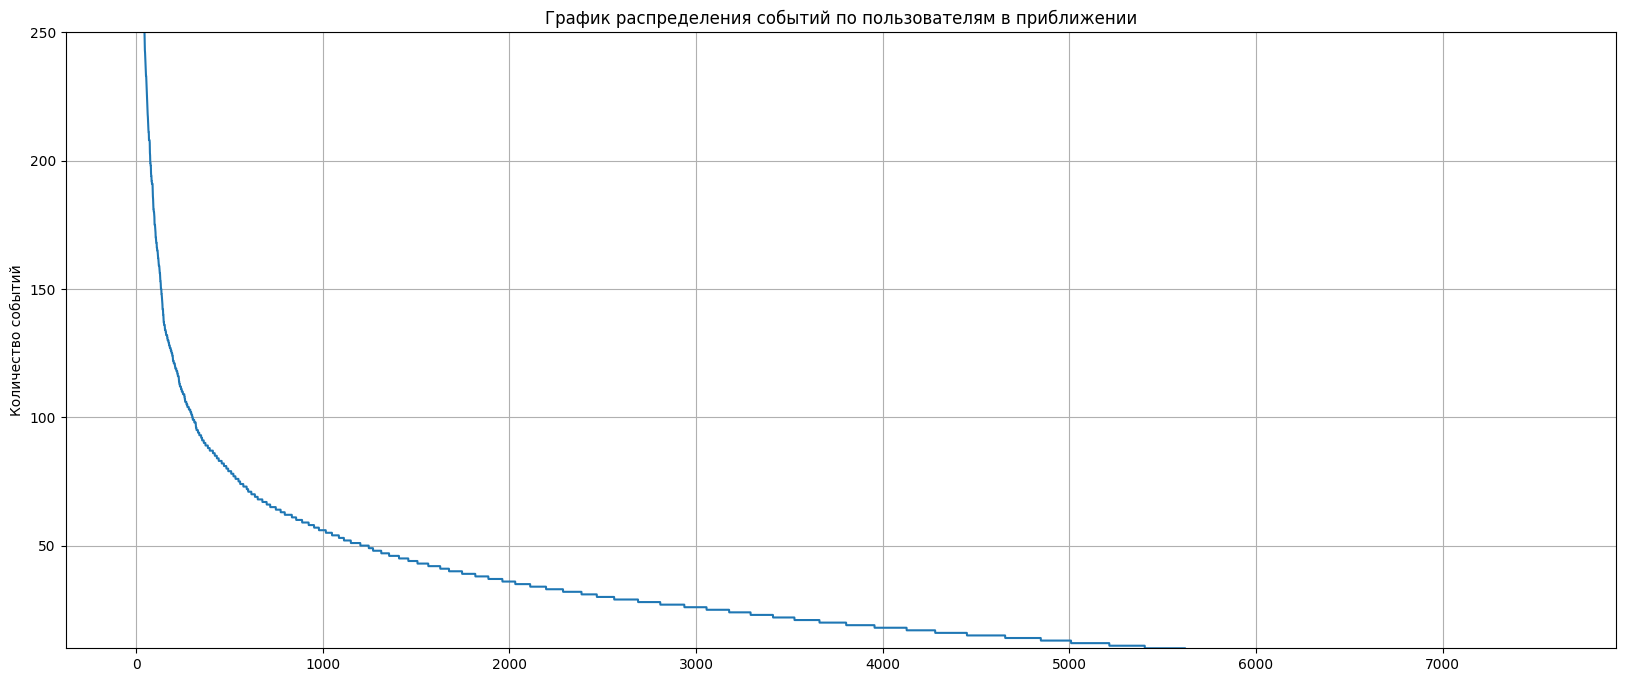

In [ ]:
number_of_events.reset_index(drop=True).plot(ylim=(10,250),figsize=(20,8))
legend = plt.legend()
legend.remove()
plt.ylabel('Количество событий')
plt.ticklabel_format(style='plain')
plt.title('График распределения событий по пользователям в приближении')
plt.grid()

In [ ]:
number_of_events.describe()

,events_number
count,7551.000000
mean,32.330287
std,65.312344
min,1.000000
25%,9.000000
50%,20.000000
75%,37.500000
max,2308.000000


In [ ]:
np.percentile(number_of_events,[95,99])

array([ 89. , 200.5])

In [ ]:
print('Если уберем самых активных пользователей, доля которых:',
      round(number_of_events[number_of_events['events_number']>np.percentile(number_of_events,[95,99])[1]].count()[0]/(df['user'].nunique())*100,2),'%.')
print('То потеряем большое количество логов -',
      round(df[df['user'].isin(number_of_events[number_of_events['events_number']>np.percentile(number_of_events,
                                                                                                [95,99])[1]].index)].shape[0]/df.shape[0]*100,2),'%.')
print('Поэтому оставим их при анализе')

Если уберем самых активных пользователей, доля которых: 1.01 %.
То потеряем большое количество логов - 14.12 %.
Поэтому оставим их при анализе


In [ ]:
print('На 1 пользователя ТЕПЕРЬ в среднем приходится',round(df.shape[0]/df['user'].nunique()),'событий, но если быть точнее то',round(df.shape[0]/df['user'].nunique(),4),'событий')
print()
print('Медианное количество событий на 1 пользователя:',round(df.pivot_table(index='user',values='time',aggfunc='count').sort_values(by='time',ascending=False).median()[0]))

На 1 пользователя ТЕПЕРЬ в среднем приходится 32 событий, но если быть точнее то 32.3303 событий

Медианное количество событий на 1 пользователя: 20


In [ ]:
print('Данные взяты за промежуток от:',df['date'].min(),'до',df['date'].max())
print('Длина анализируемого периода:',np.timedelta64 ( (df['date'].max()-df['date'].min()),'D').astype('int')+1,'дней.')

Данные взяты за промежуток от: 2019-07-25 до 2019-08-07
Длина анализируемого периода: 14 дней.


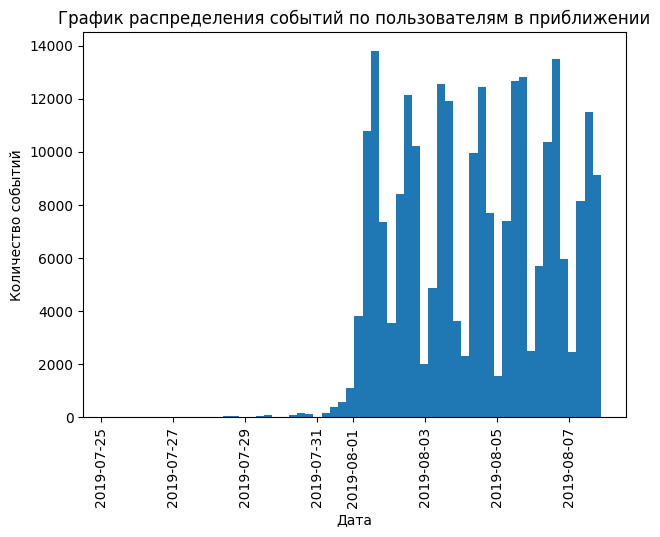

In [ ]:
df['time'].hist(figsize=(7,5),bins=60)
legend = plt.legend()
legend.remove()
plt.xticks(rotation=90)
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.title('График распределения событий по пользователям в приближении')
plt.grid();

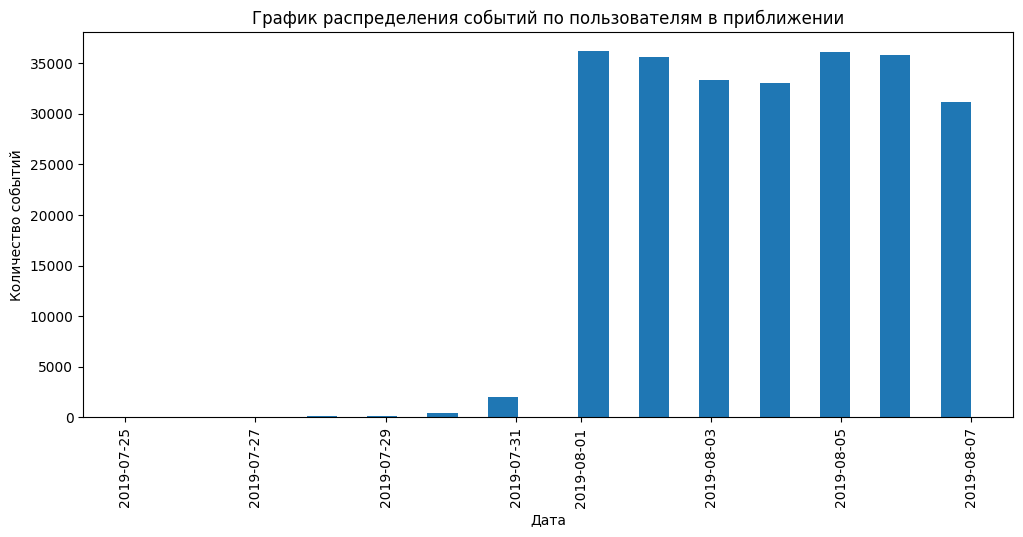

In [ ]:
df['date'].hist(figsize=(12,5),bins=28)
legend = plt.legend()
legend.remove()
plt.xticks(rotation=90)
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.title('График распределения событий по пользователям в приближении')
plt.grid();

,user
date,
2019-07-25,9
2019-07-26,31
2019-07-27,55
2019-07-28,105
2019-07-29,184
2019-07-30,413
2019-07-31,2031
2019-08-01,36229
2019-08-02,35606


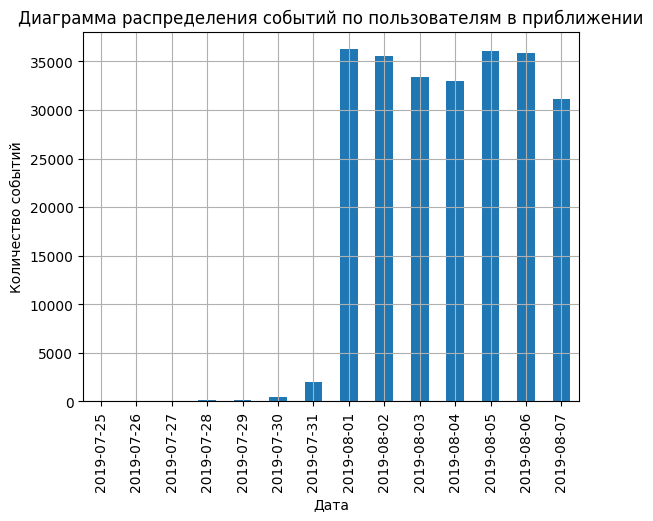

In [ ]:
display(df.pivot_table(index='date',values='user',aggfunc='count'))
df.pivot_table(index='date',values='user',aggfunc='count').plot(kind='bar')
legend = plt.legend()
legend.remove()
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.title('Диаграмма распределения событий по пользователям в приближении')
plt.grid()

Как видно данные распределены неравномерно по времени. Так, до начала августа количество данных много меньше чем после начала - граница с 31 июля по 1 августа

In [ ]:
timedf=df

Рассмотрим данные по часам

In [ ]:
timedf['hour']=pd.DatetimeIndex(timedf['time']).hour
timedf.head()

,event,user,time,exp_id,date,group,hour
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,A1,4
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,A1,11
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,B,11
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,B,11
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,B,11


In [ ]:
df=df[['event','user','time','exp_id','date','group']]
df.head(1)

,event,user,time,exp_id,date,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,A1


user
date       hour      
2019-07-25 4        1
           11       5
           14       1
           20       2
2019-07-26 3        1
...               ...
2019-08-07 17    1908
           18    1680
           19    1514
           20     949
           21      68

[284 rows x 1 columns]

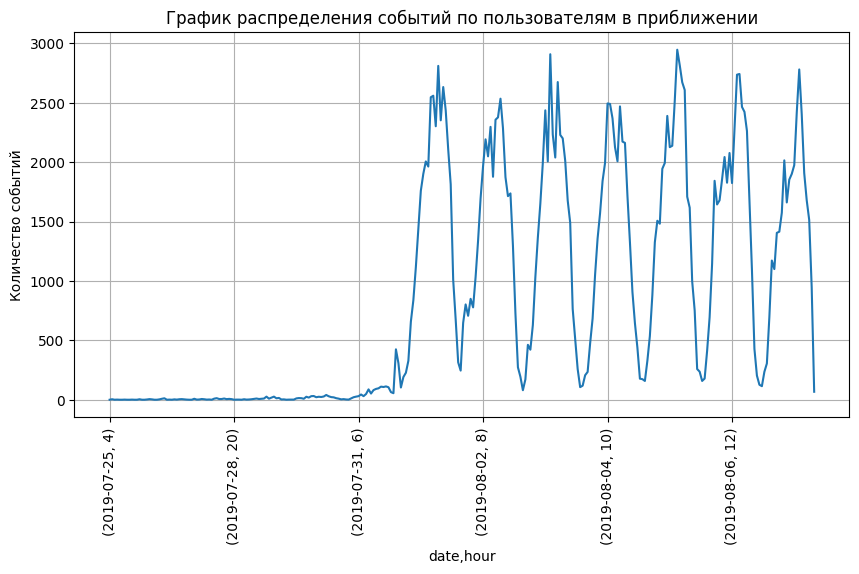

In [ ]:
display(timedf.pivot_table(index=['date','hour'],values='user',aggfunc='count'))
timedf.pivot_table(index=['date','hour'],values='user',aggfunc='count').plot(figsize=(10,5))
legend = plt.legend()
legend.remove()
plt.xticks(rotation=90)
plt.ylabel('Количество событий')
plt.title('График распределения событий по пользователям в приближении')
plt.grid()

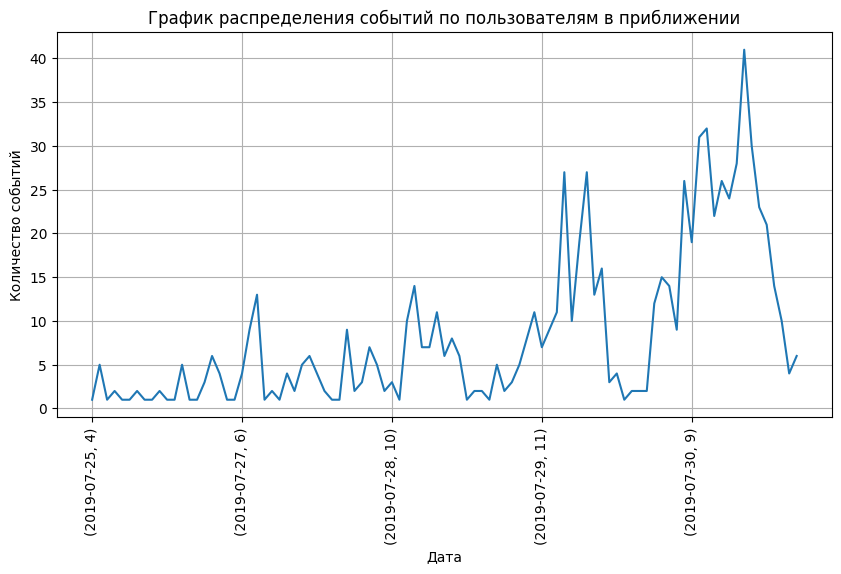

In [ ]:
timedf.query('date<datetime.date(2019,7,31)').pivot_table(index=['date','hour'],values='user',aggfunc='count').plot(figsize=(10,5))
legend = plt.legend()
legend.remove()
plt.xticks(rotation=90)
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.title('График распределения событий по пользователям в приближении')
plt.grid()

Как видно данные в июле на порядок меньше чем данные за август.

Можно убирать данные за июль с чистой душой.

In [ ]:
data=df.query('date>datetime.date(2019,7,31)')
data.head()

,event,user,time,exp_id,date,group
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,A1
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,A1
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,A1
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,A1
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,A2


In [ ]:
print('Данные взяты за промежуток от:',data['date'].min(),'до',data['date'].max())
print('Длина анализируемого периода:',np.timedelta64 ( (data['date'].max()-data['date'].min()),'D').astype('int')+1,'дней.')

Данные взяты за промежуток от: 2019-08-01 до 2019-08-07
Длина анализируемого периода: 7 дней.


In [ ]:
shape_2=data.shape[0]
quantity_user_2=data['user'].nunique()
print('Количество строк в таблице, после удаления данных:',shape_2)
print('Количество пользователй в таблице, после удаления данных:',quantity_user_2)

Количество строк в таблице, после удаления данных: 241298
Количество пользователй в таблице, после удаления данных: 7534


In [ ]:
print('До удаления данных количество СТРОК в таблице было:',shape_1, ', а стало:', shape_2)
print('Абсолютное изменение:',abs(shape_2-shape_1),'. А относительное:',round(shape_2/shape_1,4),', или', 100*round(shape_2/shape_1-1,4),'%.')
print()
print()
print('До удаления данных количество ПОЛЬЗОВАТЕЛЕЙ в таблице было:',quantity_user_1, ', а стало:', quantity_user_2)
print('Абсолютное изменение:',abs(quantity_user_2-quantity_user_1),'. А относительное:',round(quantity_user_2/quantity_user_1,5),', или', 100*round(quantity_user_2/quantity_user_1-1,6),'%.')

До удаления данных количество СТРОК в таблице было: 244126 , а стало: 241298
Абсолютное изменение: 2828 . А относительное: 0.9884 , или -1.16 %.


До удаления данных количество ПОЛЬЗОВАТЕЛЕЙ в таблице было: 7551 , а стало: 7534
Абсолютное изменение: 17 . А относительное: 0.99775 , или -0.2251 %.


Можно сделать вывод что после удаления части данных, их количество изменилось - количетсво строк уменьшилось на 15%, а количество пользователей уменьшилось на -1.2316 %.

In [ ]:
print('У нас данные данные из групп', data['group'].unique(),'. То есть из',data['group'].nunique(),'групп.')
print('У нас данные данные из групп', data['exp_id'].unique(),'. То есть из',data['exp_id'].nunique(),'групп.')

У нас данные данные из групп ['A1' 'A2' 'B'] . То есть из 3 групп.
У нас данные данные из групп [246 247 248] . То есть из 3 групп.


**Вывод:**

**В логе logs_exp.csv после предобработки: 244 126 событий и 7551 пользователей.
На 1 пользователя в среднем приходится 32 событий,
Медианное количество событий на 1 пользователя: 20.
Изначально данные были взяты за промежуток от: 2019-07-25 до 2019-08-07, а длинна анализируемого периода составляла 14 дней. Но с помощью графиков и таблиц распределения по датам удалось выяснить, что до начала августа 2019 года количество данных мало и на порядок меньше чем в августе. По этой причине решено их не учитывать при анализе. После удаления неполных данных будет рассмотрен промежуток от: 2019-08-01 до 2019-08-07, который учитывает только полные данные. Длина нового анализируемого периода - 7 дней.**

**Можно сделать вывод что после удаления части данных, их количество изменилось с 244 126  по 241 298 = -2 828 . Относительное изменение: в 0.9884 , или уменьшение на 1.16 %.**

**До удаления данных количество ПОЛЬЗОВАТЕЛЕЙ в таблице было: 7 551 , а стало: 7 534 = 17 . Относительное изменение: в 0.99775 , или уменьшение на 0.2251 %.**

**Данные из 3 групп присутствуют в датасете.**

**------------------------------------------------------------------------------------------------------------------------------------------------**

## - Проанализируем воронку событий

In [ ]:
print('В логах есть следующие возможные типы событий', data['event'].unique(),'. То есть',data['event'].nunique(),'типов событий.')
print()
for x in data['event'].unique():
    print(x)

В логах есть следующие возможные типы событий ['Tutorial' 'MainScreenAppear' 'OffersScreenAppear' 'CartScreenAppear'
 'PaymentScreenSuccessful'] . То есть 5 типов событий.

Tutorial
MainScreenAppear
OffersScreenAppear
CartScreenAppear
PaymentScreenSuccessful


Количество всех пользователей: 7534
Количество всех событий: 241298


,events_numbers,users,events_%_abs,user_%_abs,events/user
event,,,,,
MainScreenAppear,117431,7419,48.67,98.47,15.83
OffersScreenAppear,46350,4593,19.21,60.96,10.09
CartScreenAppear,42365,3734,17.56,49.56,11.35
PaymentScreenSuccessful,34113,3539,14.14,46.97,9.64
Tutorial,1039,840,0.43,11.15,1.24


Как видно чаще всего пользователи повторно пользуются главным экраном, реже всем остальным, но туториалом почти никогда повторно не пользуются


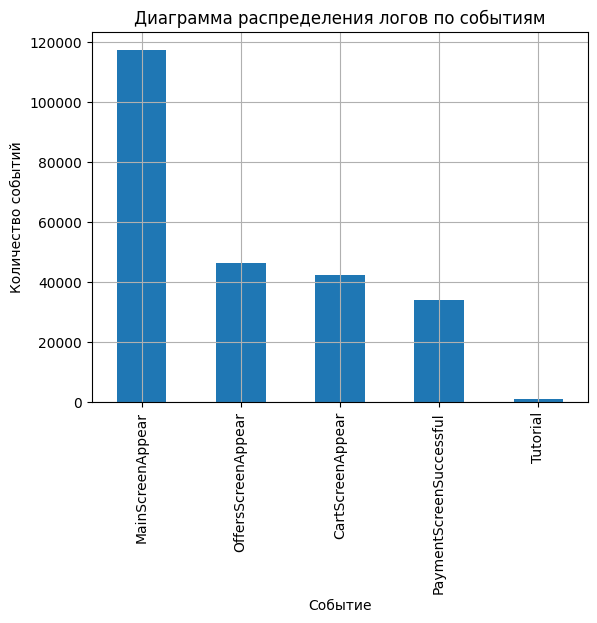

In [ ]:
data_events=data.pivot_table(index='event',values='user',aggfunc=['count','nunique'])
data_events.columns=['events_numbers','users']
data_events['events_%_abs']=round(data_events['events_numbers']/shape_2*100,2)
data_events['user_%_abs']=round(data_events['users']/data['user'].nunique()*100,2)
data_events['events/user']=round(data_events['events_numbers']/data_events['users'],2)
data_events=data_events.sort_values(by='events_%_abs',ascending=False)
print('Количество всех пользователей:',data['user'].nunique())
print('Количество всех событий:',shape_2)
display(data_events)
print('Как видно чаще всего пользователи повторно пользуются главным экраном, реже всем остальным, но туториалом почти никогда повторно не пользуются')
data_events['events_numbers'].plot(kind='bar')
legend = plt.legend()
legend.remove()
plt.ylabel('Количество событий')
plt.xlabel('Событие')
plt.title('Диаграмма распределения логов по событиям')
plt.grid()


Всего уникальных пользователей: 7534


,users,user_%_abs
event,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


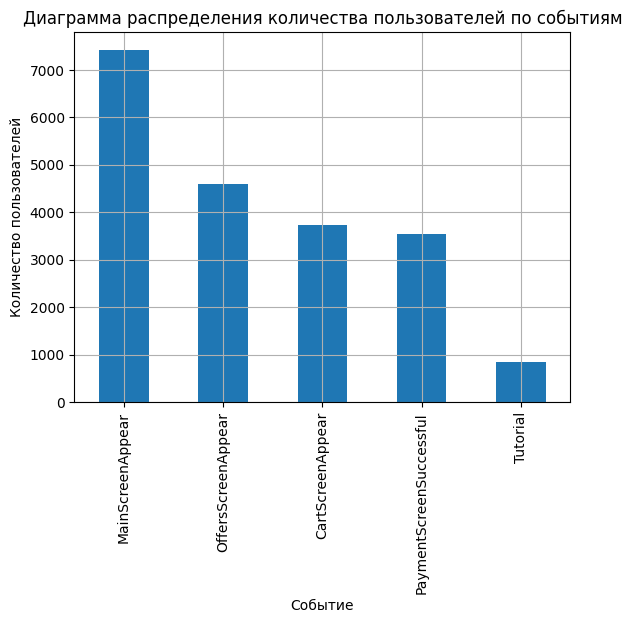

In [ ]:
print('Всего уникальных пользователей:',data['user'].nunique())
display(data_events.sort_values(by='users',ascending=False)[['users','user_%_abs']])
data_events['users'].plot(kind='bar')
legend = plt.legend()
legend.remove()
plt.ylabel('Количество пользователей')
plt.xlabel('Событие')
plt.title('Диаграмма распределения количества пользователей по событиям')
plt.grid()

Логичнее что туториал или обучение пользователя должно идти первым при заходе. Все же остальные этапы стоят в правильном порядке. Видимо пользователи порпускают обучение и оно считается не выполненным. То есть на 1 этап - появление главного экрана можно попасть миновав 0 шаг.

Не совсем понятно как и в какой момент учитываются события Tutorial  - по логике при первом заходе в приложении у всех пользователей, а так же при нажимании в настройках если что-то не понятно. То есть с одной стороны это может быть обязательное событие, но видимо здесь это не так.

Очевидно, что гланым событием для нас явлется оплата заказа - PaymentScreenSuccessful. То есть нам важно понять как пользователи доходят до покупки (одно из условий проекта). Довольно сложно отследить все движение или последовательности событий всех пользователей, поэтому хотя бы наличией связий и различий между выборками разных действий - попробуем понять как в среднем ведут себя клиенты.

In [ ]:
def event_user_percenatge(event_name):
    scr_users=data.query('event==@event_name')['user'].unique()
    not_scr_users=data[np.logical_not(data['user'].isin(scr_users))]
    event_not_scr_users=not_scr_users.pivot_table(index='event',values='user',aggfunc=['count','nunique'])
    event_not_scr_users.columns=['events_numbers','users']
    event_not_scr_users = event_not_scr_users.append(event_not_scr_users.cumsum().tail(1).reset_index(drop=True))
    event_not_scr_users['events_%_abs']=round(event_not_scr_users['events_numbers']/shape_2*100,2)
    event_not_scr_users['user_%_abs']=round(event_not_scr_users['users']/data['user'].nunique()*100,2)
    event_not_scr_users['events_%_rel']=round(event_not_scr_users['events_numbers']/event_not_scr_users.loc[0,'events_numbers']*100,2)
    event_not_scr_users['users_%_rel']=round(event_not_scr_users['users']/event_not_scr_users.loc[0,'users']*100,2)


    scr_users1=data[data['user'].isin(scr_users)]
    event_scr_users=scr_users1.pivot_table(index='event',values='user',aggfunc=['count','nunique'])
    event_scr_users.columns=['events_numbers','users']
    event_scr_users=event_scr_users.drop([event_name])
    event_scr_users = event_scr_users.append(event_scr_users.cumsum().tail(1).reset_index(drop=True))
    event_scr_users['events_%_abs']=round(event_scr_users['events_numbers']/shape_2*100,2)
    event_scr_users['user_%_abs']=round(event_scr_users['users']/data['user'].nunique()*100,2)
    event_scr_users['events_%_rel']=round(event_scr_users['events_numbers']/event_scr_users.loc[0,'events_numbers']*100,2)
    event_scr_users['users_%_rel']=round(event_scr_users['users']/event_scr_users.loc[0,'users']*100,2)
    return print('Таблица где убраны пользователи совершавшие данное событие:'),display(event_not_scr_users),print('Таблица где убраны пользователи НЕ совершавшие данное событие:'), display(event_scr_users)

In [ ]:
event_user_percenatge("MainScreenAppear")

<ipython-input-38-a64816a5cacd>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  event_not_scr_users = event_not_scr_users.append(event_not_scr_users.cumsum().tail(1).reset_index(drop=True))


Таблица где убраны пользователи совершавшие данное событие:


<ipython-input-38-a64816a5cacd>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  event_scr_users = event_scr_users.append(event_scr_users.cumsum().tail(1).reset_index(drop=True))


,events_numbers,users,events_%_abs,user_%_abs,events_%_rel,users_%_rel
CartScreenAppear,909,99,0.38,1.31,34.65,31.73
OffersScreenAppear,949,111,0.39,1.47,36.18,35.58
PaymentScreenSuccessful,758,98,0.31,1.30,28.90,31.41
Tutorial,7,4,0.00,0.05,0.27,1.28
0,2623,312,1.09,4.14,100.00,100.00


Таблица где убраны пользователи НЕ совершавшие данное событие:


,events_numbers,users,events_%_abs,user_%_abs,events_%_rel,users_%_rel
CartScreenAppear,41456,3635,17.18,48.25,34.19,29.33
OffersScreenAppear,45401,4482,18.82,59.49,37.45,36.16
PaymentScreenSuccessful,33355,3441,13.82,45.67,27.51,27.76
Tutorial,1032,836,0.43,11.10,0.85,6.75
0,121244,12394,50.25,164.51,100.00,100.00


(None, None, None, None)

Различие в поведение пользователей которые не смотрели главный экран вовсе и которые обязательно его смотрели не сильное, что говорит против гипотезы, что главный экран и экран с предложением это альтернатиынй варианты или как-бы конкуренты в воронке. Скорее всего они дополняют друг-друга. Возможно предложение поступает с главного экрана. То есть сначала нужно зайти на гланый экран и потом можно получить предложение - возможно это рекламные банеры справа и т.п.

In [ ]:
event_user_percenatge("OffersScreenAppear")

<ipython-input-38-a64816a5cacd>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  event_not_scr_users = event_not_scr_users.append(event_not_scr_users.cumsum().tail(1).reset_index(drop=True))


Таблица где убраны пользователи совершавшие данное событие:


<ipython-input-38-a64816a5cacd>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  event_scr_users = event_scr_users.append(event_scr_users.cumsum().tail(1).reset_index(drop=True))


,events_numbers,users,events_%_abs,user_%_abs,events_%_rel,users_%_rel
CartScreenAppear,120,55,0.05,0.73,0.27,1.72
MainScreenAppear,43227,2937,17.91,38.98,98.99,91.92
PaymentScreenSuccessful,17,7,0.01,0.09,0.04,0.22
Tutorial,304,196,0.13,2.60,0.70,6.13
0,43668,3195,18.10,42.41,100.00,100.00


Таблица где убраны пользователи НЕ совершавшие данное событие:


,events_numbers,users,events_%_abs,user_%_abs,events_%_rel,users_%_rel
CartScreenAppear,42245,3679,17.51,48.83,27.93,29.82
MainScreenAppear,74204,4482,30.75,59.49,49.05,36.33
PaymentScreenSuccessful,34096,3532,14.13,46.88,22.54,28.63
Tutorial,735,644,0.30,8.55,0.49,5.22
0,151280,12337,62.69,163.75,100.00,100.00


(None, None, None, None)

Тут же поведение пользователей существенно отличается - пользователи что не пользуются предложением практически не совершают покупок - в основном они только что и делают, как проводят свое время на главном экране.

In [ ]:
event_user_percenatge("CartScreenAppear")

<ipython-input-38-a64816a5cacd>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  event_not_scr_users = event_not_scr_users.append(event_not_scr_users.cumsum().tail(1).reset_index(drop=True))


Таблица где убраны пользователи совершавшие данное событие:


<ipython-input-38-a64816a5cacd>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  event_scr_users = event_scr_users.append(event_scr_users.cumsum().tail(1).reset_index(drop=True))


,events_numbers,users,events_%_abs,user_%_abs,events_%_rel,users_%_rel
MainScreenAppear,57876,3784,23.99,50.23,96.09,75.66
OffersScreenAppear,1932,914,0.80,12.13,3.21,18.28
PaymentScreenSuccessful,5,5,0.00,0.07,0.01,0.10
Tutorial,417,298,0.17,3.96,0.69,5.96
0,60230,5001,24.96,66.38,100.00,100.00


Таблица где убраны пользователи НЕ совершавшие данное событие:


,events_numbers,users,events_%_abs,user_%_abs,events_%_rel,users_%_rel
MainScreenAppear,59555,3635,24.68,48.25,42.94,31.91
OffersScreenAppear,44418,3679,18.41,48.83,32.02,32.30
PaymentScreenSuccessful,34108,3534,14.14,46.91,24.59,31.03
Tutorial,622,542,0.26,7.19,0.45,4.76
0,138703,11390,57.48,151.18,100.00,100.00


(None, None, None, None)

Как видно существует малая группа пользователей что каким-то образом миновали корзину. Их поведение следующее -  в основном они так же крутятся вокруг главного экрана но видят предложение чаще, что скорее говорит о том, что у пользователей что не видели корзину, но видели предложениеи поведение более нормальное, чем у пользователей что видели корзину но не видели оффер. Понятно что на такую малую группу не стоит ориентироваться и из такой малой группы нужно делать выводы осторожно.

In [ ]:
event_user_percenatge("PaymentScreenSuccessful")

<ipython-input-38-a64816a5cacd>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  event_not_scr_users = event_not_scr_users.append(event_not_scr_users.cumsum().tail(1).reset_index(drop=True))


Таблица где убраны пользователи совершавшие данное событие:


<ipython-input-38-a64816a5cacd>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  event_scr_users = event_scr_users.append(event_scr_users.cumsum().tail(1).reset_index(drop=True))


,events_numbers,users,events_%_abs,user_%_abs,events_%_rel,users_%_rel
CartScreenAppear,461,200,0.19,2.65,0.72,3.56
MainScreenAppear,60899,3978,25.24,52.80,94.52,70.88
OffersScreenAppear,2573,1061,1.07,14.08,3.99,18.91
Tutorial,495,373,0.21,4.95,0.77,6.65
0,64428,5612,26.70,74.49,100.00,100.00


Таблица где убраны пользователи НЕ совершавшие данное событие:


,events_numbers,users,events_%_abs,user_%_abs,events_%_rel,users_%_rel
CartScreenAppear,41904,3534,17.37,46.91,29.35,32.20
MainScreenAppear,56532,3441,23.43,45.67,39.60,31.36
OffersScreenAppear,43777,3532,18.14,46.88,30.67,32.19
Tutorial,544,467,0.23,6.20,0.38,4.26
0,142757,10974,59.16,145.66,100.00,100.00


(None, None, None, None)

Пользователи, которые не видели экарн с упешной оплатой, а то есть ничего не покупали - почти не заходили в корзину - из чего напрашивается условия для покупки - это корзина - без корзины пользователи не доходят до покупки. Вместо этого они опять отдыхают на главном экране. Так же такие пользовтели видят меньше предложений.

In [ ]:
event_user_percenatge("Tutorial")

Таблица где убраны пользователи совершавшие данное событие:


<ipython-input-38-a64816a5cacd>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  event_not_scr_users = event_not_scr_users.append(event_not_scr_users.cumsum().tail(1).reset_index(drop=True))
<ipython-input-38-a64816a5cacd>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  event_scr_users = event_scr_users.append(event_scr_users.cumsum().tail(1).reset_index(drop=True))


,events_numbers,users,events_%_abs,user_%_abs,events_%_rel,users_%_rel
CartScreenAppear,35695,3192,14.79,42.37,17.04,19.00
MainScreenAppear,105735,6583,43.82,87.38,50.47,39.19
OffersScreenAppear,38317,3949,15.88,52.42,18.29,23.51
PaymentScreenSuccessful,29763,3072,12.33,40.78,14.21,18.29
0,209510,16796,86.83,222.94,100.00,100.00


Таблица где убраны пользователи НЕ совершавшие данное событие:


,events_numbers,users,events_%_abs,user_%_abs,events_%_rel,users_%_rel
CartScreenAppear,6670,542,2.76,7.19,21.69,21.78
MainScreenAppear,11696,836,4.85,11.10,38.04,33.59
OffersScreenAppear,8033,644,3.33,8.55,26.12,25.87
PaymentScreenSuccessful,4350,467,1.80,6.20,14.15,18.76
0,30749,2489,12.74,33.04,100.00,100.00


(None, None, None, None)

Рассмотрели как отличается поведение пользователей проходивших и не проходивших туториал. Те что проходили меньше зависают на главном экране и немного больше покупают.

Из всего вышеперечисленного можно сделать вывод, что пользователи заходя в приложение не понимают что им делать. Сначал можно подумать что враг покупок это главный экран. Но скорее всего - недостаточное понимание у пользователей что им делать после того как они открыли главный экран - нужно либо улучшать качество туториала, где рассказывать как и зачем добавлять товары в корзину, либо слать больше офферов, а так же улчшать таргет.

После этого в голове укладывается идеальная картина воронки. При первых заходах в приложение пользователь должен пройти обучение. Нужно улучшть качество обучения, что бы юзерам было интерсно его проходить. Затем он попадает на главный экран - это и есть исток, или базовый уровень с которым нужно работать. Дальше ему приходить или он сам нажимает на оффер - тут можно подключить таргетинг, что бы рекомендовать пользователю нужные ему товары. Затем нужно чтобы пользователь добавил интересующий товар в корзину. Здесь можно сделать всячиские анимации и мигающию корзину в шапке сайта, что на нее зотелось нажать. Далее нужно предоставить/отобразить все варинаты оплаты - что бы пользователь хотел получить вещь. А что бы ускорить его выбор можно добавить скидку или бесплатную доставку для первых разов.

**Tutorial ---> Main Screen Appear ---> Offers Screen Appear ---> Cart Screen Appear ---> Payment Screen Successful**

При расчете воронки не будем учитывать туториал - потому что видимо он не обязательный и его пользователи редко используют. Возможно это эксперементальная функция и обучение можно пройти полазив в приложении и/или в настроках.

,event,users,conv_by_step,conv
0,MainScreenAppear,7419,1.00,1.00
1,OffersScreenAppear,4593,0.62,0.62
2,CartScreenAppear,3734,0.81,0.50
3,PaymentScreenSuccessful,3539,0.95,0.48


<Axes: title={'center': 'Конверсия воронки'}, xlabel='event'>

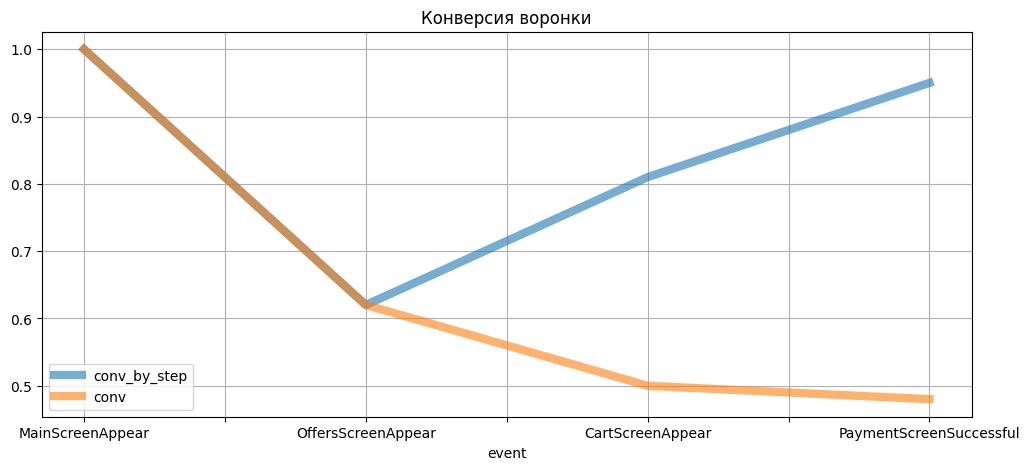

In [ ]:
users_by_events=data_events['users'].drop(['Tutorial']).reset_index()
users_by_events['conv_by_step']=round(users_by_events['users']/users_by_events['users'].shift(fill_value=users_by_events.loc[0,'users']),2)
users_by_events['conv']=round(users_by_events['users']/users_by_events.loc[0,'users'],2)
display(users_by_events)
users_by_events.drop(['users'],axis=1).plot(x='event',alpha=0.6,grid=True,figsize=(12,5),title='Конверсия воронки',linewidth=6)

In [ ]:
fig = px.funnel(users_by_events, x='conv', y='event')
fig.show()

Общая конверсия падает и это нормально, но вот конверсия по шагам после OffersScreenAppear - растет.

Самая большая просадка случается при переходе с главного экрана на предложение - что подтверждает версию выдвинутую ранее. На это шаге и теряется больше всего пользователей - 42%. 53% процента пользователей не доходят до оплаты, а 47% доходят.

**Вывод:**

**В логах есть следующие возможные типы событий:
Tutorial, MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful. То есть 5 типов событий.**

**Количество событий, которые совершили пользователи:**

* MainScreenAppear - 117 431;

* OffersScreenAppear - 46 350;

* CartScreenAppear - 42 365;

* PaymentScreenSuccessful - 34 113;

* Tutorial - 1 039;

* Всего: 241 298.

**Количество пользователей, совершивших событий и их доля от числа всех событий:**

* MainScreenAppear - 7 419 - 98%;

* OffersScreenAppear - 4 593 - 61%;

* CartScreenAppear - 3 734 - 50%;

* PaymentScreenSuccessful - 3 539 - 47%;

* Tutorial - 840 - 11%;

* Всего: 7 534 - 100%.

**События происходят в следующем порядке: Main Screen Appear ---> Offers Screen Appear ---> Cart Screen Appear ---> Payment Screen Successful. Из цепочки выбивается Tutorial с ним либо есть проблемы либо он просто не нужен при анализе.**

**При переходе с MainScreenAppear  на OffersScreenAppear  конверсия = 0.62; при переходе с шага OffersScreenAppear на шаг CartScreenAppear  общая конверсия = 0,5 , а шаговая конверсия = 0,81; с CartScreenAppear на PaymentScreenSuccessful  - общая конверсия = 0.48, шаговая = 0.95. Больше всего теряется на 1 шаге - нужно обратить на это внимание. С начала взаимодействия до оплаты доходит 52%.**

Проблема обнаружена - провал на первом шаге: от `MainScreenAppear` к `OffersScreenAppear`. Вероятно, нужно лучше прорабатывать механику, чтобы пользователи переходили к `OffersScreen`.
    
`Tutorial`, можно просто пропустить.
</div>


**------------------------------------------------------------------------------------------------------------------------------------------------**

## - A/A/B-тест и анализ его результатов

Количество событий в каждой группе:


,event_number,events_pct
group,,
A1,79425,32.92
A2,77147,31.97
B,84726,35.11


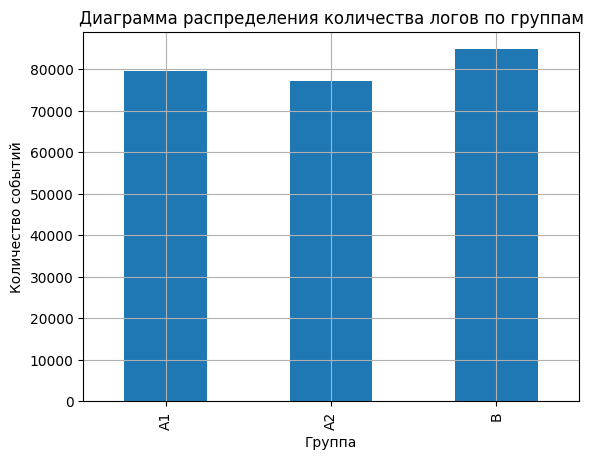

In [ ]:
data_group_events=data.pivot_table(index='group',values='user',aggfunc='count')
data_group_events.columns=['event_number']
data_group_events['events_pct']=round(data_group_events/data_group_events.sum()*100,2)
print('Количество событий в каждой группе:')
display(data_group_events)
data_group_events['event_number'].plot(kind='bar')
plt.ylabel('Количество событий')
plt.xlabel('Группа')
plt.title('Диаграмма распределения количества логов по группам')
plt.grid()

Количество пользователей в каждой группе:


,user,users_pct
group,,
A1,2484,32.97
A2,2513,33.36
B,2537,33.67


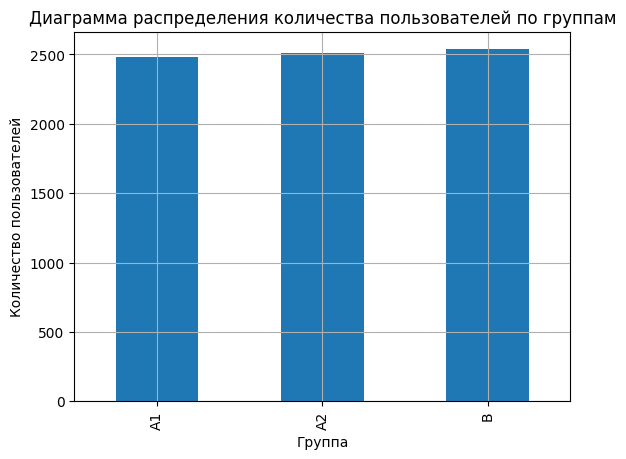

In [ ]:
data_group_users=data.pivot_table(index='group',values='user',aggfunc='nunique')
print('Количество пользователей в каждой группе:')
data_group_users['users_pct']=round(data_group_users/data_group_users.sum()*100,2)
display(data_group_users)
data_group_users['user'].plot(kind='bar')
plt.ylabel('Количество пользователей')
plt.xlabel('Группа')
plt.title('Диаграмма распределения количества пользователей по группам')
plt.grid()

**H0 - различий в среднем количестве заказов между группами нет**

**H1 - различия в среднем количестве заказов между группами есть**

In [ ]:
alpha = 0.05
print('Количество пользователей из группы А1 - 246:',data.query('group=="A1"')['user'].nunique(),'человек.')
print('Количество пользователей из группы А2 - 247:',data.query('group=="A2"')['user'].nunique(),'человек.')
print()
print('Количество Покупателей из группы А1 - 246:',data.query('event=="PaymentScreenSuccessful"').query('group=="A1"')['user'].nunique(),'человек.')
print('Количество Покупателей из группы А2 - 247:',data.query('event=="PaymentScreenSuccessful"').query('group=="A2"')['user'].nunique(),'человек.')

purchases = np.array([data.query('event=="PaymentScreenSuccessful"').query('group=="A1"')['user'].nunique(), data.query('event=="PaymentScreenSuccessful"').query('group=="A2"')['user'].nunique()])
leads = np.array([data.query('group=="A1"')['user'].nunique(), data.query('group=="A2"')['user'].nunique()])
print()
print()
print('purchases:',purchases)
print('leads:',leads)

Количество пользователей из группы А1 - 246: 2484 человек.
Количество пользователей из группы А2 - 247: 2513 человек.

Количество Покупателей из группы А1 - 246: 1200 человек.
Количество Покупателей из группы А2 - 247: 1158 человек.


purchases: [1200 1158]
leads: [2484 2513]


In [ ]:
p1=purchases[0]/leads[0]
p2=purchases[1]/leads[1]
p_combined=purchases.sum()/leads.sum()
difference=p1-p2


z_value = difference/mth.sqrt(p_combined*(1-p_combined)*(1/leads[0]+1/leads[1]))
distr = st.norm(0, 1)



p_value = (1-distr.cdf(abs(z_value)))*2

print('p-значение: ', p_value)

if p_value<alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )


p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Между контрольными группами нет статзначимых различий

In [ ]:
most_popular_event=data_events['events_numbers'][data_events['events_numbers']==data_events['events_numbers'].max()].reset_index()['event'][0]
print('Самое популярное событие:',most_popular_event)

Самое популярное событие: MainScreenAppear


In [ ]:
event_group=data.pivot_table(index='event',columns='group',values='user',aggfunc='nunique').sort_values(by='B',ascending=False)
event_group=pd.concat([event_group,data_group_users.T[data_group_users.T.index=='user']], axis=0)
event_group['united']=event_group['A1']+event_group['A2']
print('Число пользователей, совершивших самое популярное событие в каждой из контрольных групп:')
display(event_group[event_group.index==most_popular_event][['A1','A2']])
print()
print()
print('Доля пользователей, совершивших самое популярное событие в каждой из контрольных групп:')
display(round(event_group[event_group.index==most_popular_event][['A1','A2']]/event_group[event_group.index=='user'][['A1','A2']].values,3))
print()
print()
print('Число пользователей, совершивших события в каждой из групп:')
display(event_group)
print()
print()
print('Доля пользователей, совершивших события в каждой из групп:')
display(round(event_group/event_group[event_group.index=='user'].values,3))

Число пользователей, совершивших самое популярное событие в каждой из контрольных групп:


group,A1,A2
MainScreenAppear,2450.0,2476.0




Доля пользователей, совершивших самое популярное событие в каждой из контрольных групп:


group,A1,A2
MainScreenAppear,0.986,0.985




Число пользователей, совершивших события в каждой из групп:


group,A1,A2,B,united
MainScreenAppear,2450.0,2476.0,2493.0,4926.0
OffersScreenAppear,1542.0,1520.0,1531.0,3062.0
CartScreenAppear,1266.0,1238.0,1230.0,2504.0
PaymentScreenSuccessful,1200.0,1158.0,1181.0,2358.0
Tutorial,278.0,283.0,279.0,561.0
user,2484.0,2513.0,2537.0,4997.0




Доля пользователей, совершивших события в каждой из групп:


group,A1,A2,B,united
MainScreenAppear,0.986,0.985,0.983,0.986
OffersScreenAppear,0.621,0.605,0.603,0.613
CartScreenAppear,0.510,0.493,0.485,0.501
PaymentScreenSuccessful,0.483,0.461,0.466,0.472
Tutorial,0.112,0.113,0.110,0.112
user,1.000,1.000,1.000,1.000


In [ ]:
data.head()

,event,user,time,exp_id,date,group
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,A1
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,A1
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,A1
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,A1
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,A2


Проверим будет ли отличие между группами статистически достоверным:

In [ ]:
event_group1=event_group
event_group1

group,A1,A2,B,united
MainScreenAppear,2450.0,2476.0,2493.0,4926.0
OffersScreenAppear,1542.0,1520.0,1531.0,3062.0
CartScreenAppear,1266.0,1238.0,1230.0,2504.0
PaymentScreenSuccessful,1200.0,1158.0,1181.0,2358.0
Tutorial,278.0,283.0,279.0,561.0
user,2484.0,2513.0,2537.0,4997.0


In [ ]:
def event_z_value(alpha,chosen_event,first_group,second_group):
    only_event = np.array([event_group1.loc[chosen_event,first_group],event_group1.loc[chosen_event,second_group]])
    leads  = np.array([event_group1.loc['user',first_group], event_group1.loc['user',second_group]])

    p1=only_event[0]/leads[0]
    p2=only_event[1]/leads[1]
    p_combined=only_event.sum()/leads.sum()
    difference=p1-p2

    event_group1.loc[chosen_event,str(first_group)+'_rel']=p1
    event_group1.loc[chosen_event,str(second_group)+'_rel']=p2
    z_value = difference/mth.sqrt(p_combined*(1-p_combined)*(1/leads[0]+1/leads[1]))
    distr = st.norm(0, 1)

    p_value = round((1-distr.cdf(abs(z_value)))*2,3)
    event_group1.loc[chosen_event,'p_value']=p_value


    if p_value<alpha:
        event_group1.loc[chosen_event,'hypotises_adoption']='Отвергаем нулевую гипотезу'
        event_group1.loc[chosen_event,'hypotises_decision']='Между долями есть значимая разница'

    else:
        event_group1.loc[chosen_event,'hypotises_adoption']='Не получилось отвергнуть нулевую гипотезу'
        event_group1.loc[chosen_event,'hypotises_decision']='Нет оснований считать доли разными'

    return event_group1

Применим поправку на множественность сравнений Бонферрони: bonferroni_alpha=alpha/m, где m - число гипотез. У меня 4 сравнения групп в которых по 5 элементов сравнения (событий) - значит 4*5=20

In [ ]:
alpha=0.1
bonferroni_alpha=alpha/(5*4)
bonferroni_alpha

0.005

In [ ]:
data.head(1)

,event,user,time,exp_id,date,group
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,A1


In [ ]:
data.pivot_table(index='group',values='user',aggfunc='nunique')

,user
group,
A1,2484
A2,2513
B,2537


In [ ]:
for x in event_group.drop('user').index:
    event_z_value(alpha=bonferroni_alpha, chosen_event=x,first_group='A1',second_group='A2')
event_group1.drop(columns=['B','united'])

group,A1,A2,A1_rel,A2_rel,p_value,hypotises_adoption,hypotises_decision
MainScreenAppear,2450.0,2476.0,0.986312,0.985277,0.757,Не получилось отвергнуть нулевую гипотезу,Нет оснований считать доли разными
OffersScreenAppear,1542.0,1520.0,0.620773,0.604855,0.248,Не получилось отвергнуть нулевую гипотезу,Нет оснований считать доли разными
CartScreenAppear,1266.0,1238.0,0.509662,0.492638,0.229,Не получилось отвергнуть нулевую гипотезу,Нет оснований считать доли разными
PaymentScreenSuccessful,1200.0,1158.0,0.483092,0.460804,0.115,Не получилось отвергнуть нулевую гипотезу,Нет оснований считать доли разными
Tutorial,278.0,283.0,0.111916,0.112614,0.938,Не получилось отвергнуть нулевую гипотезу,Нет оснований считать доли разными
user,2484.0,2513.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
for x in event_group.drop('user').index:
    event_z_value(alpha=bonferroni_alpha, chosen_event=x,first_group='A1',second_group='B')
event_group1.drop(columns=['A2','united'])

group,A1,B,A1_rel,A2_rel,p_value,hypotises_adoption,hypotises_decision,B_rel
MainScreenAppear,2450.0,2493.0,0.986312,0.985277,0.295,Не получилось отвергнуть нулевую гипотезу,Нет оснований считать доли разными,0.982657
OffersScreenAppear,1542.0,1531.0,0.620773,0.604855,0.208,Не получилось отвергнуть нулевую гипотезу,Нет оснований считать доли разными,0.603469
CartScreenAppear,1266.0,1230.0,0.509662,0.492638,0.078,Не получилось отвергнуть нулевую гипотезу,Нет оснований считать доли разными,0.484825
PaymentScreenSuccessful,1200.0,1181.0,0.483092,0.460804,0.212,Не получилось отвергнуть нулевую гипотезу,Нет оснований считать доли разными,0.465510
Tutorial,278.0,279.0,0.111916,0.112614,0.826,Не получилось отвергнуть нулевую гипотезу,Нет оснований считать доли разными,0.109972
user,2484.0,2537.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for x in event_group.drop('user').index:
    event_z_value(alpha=bonferroni_alpha, chosen_event=x,first_group='A2',second_group='B')
event_group1.drop(columns=['A1','united'])

group,A2,B,A1_rel,A2_rel,p_value,hypotises_adoption,hypotises_decision,B_rel
MainScreenAppear,2476.0,2493.0,0.986312,0.985277,0.459,Не получилось отвергнуть нулевую гипотезу,Нет оснований считать доли разными,0.982657
OffersScreenAppear,1520.0,1531.0,0.620773,0.604855,0.920,Не получилось отвергнуть нулевую гипотезу,Нет оснований считать доли разными,0.603469
CartScreenAppear,1238.0,1230.0,0.509662,0.492638,0.579,Не получилось отвергнуть нулевую гипотезу,Нет оснований считать доли разными,0.484825
PaymentScreenSuccessful,1158.0,1181.0,0.483092,0.460804,0.737,Не получилось отвергнуть нулевую гипотезу,Нет оснований считать доли разными,0.465510
Tutorial,283.0,279.0,0.111916,0.112614,0.765,Не получилось отвергнуть нулевую гипотезу,Нет оснований считать доли разными,0.109972
user,2513.0,2537.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for x in event_group.drop('user').index:
    event_z_value(alpha=bonferroni_alpha, chosen_event=x,first_group='united',second_group='B')
event_group1.drop(columns=['A1','A2'])

group,B,united,A1_rel,A2_rel,p_value,hypotises_adoption,hypotises_decision,B_rel,united_rel
MainScreenAppear,2493.0,4926.0,0.986312,0.985277,0.294,Не получилось отвергнуть нулевую гипотезу,Нет оснований считать доли разными,0.982657,0.985791
OffersScreenAppear,1531.0,3062.0,0.620773,0.604855,0.434,Не получилось отвергнуть нулевую гипотезу,Нет оснований считать доли разными,0.603469,0.612768
CartScreenAppear,1230.0,2504.0,0.509662,0.492638,0.182,Не получилось отвергнуть нулевую гипотезу,Нет оснований считать доли разными,0.484825,0.501101
PaymentScreenSuccessful,1181.0,2358.0,0.483092,0.460804,0.600,Не получилось отвергнуть нулевую гипотезу,Нет оснований считать доли разными,0.465510,0.471883
Tutorial,279.0,561.0,0.111916,0.112614,0.765,Не получилось отвергнуть нулевую гипотезу,Нет оснований считать доли разными,0.109972,0.112267
user,2537.0,4997.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
display((round(pd.DataFrame({'A1/A2': event_group['A1']/event_group['A2'],
              'A1/B':event_group['A1']/event_group['B'],
               'A2/B': event_group['A2']/event_group['B']
             }),3)-1)*100)
display((round(1/pd.DataFrame({'A2/A1': event_group['A1']/event_group['A2'],
              'B/A1':event_group['A1']/event_group['B'],
               'B/A2': event_group['A2']/event_group['B']
             }),3)-1)*100)

,A1/A2,A1/B,A2/B
MainScreenAppear,-1.1,-1.7,-0.7
OffersScreenAppear,1.4,0.7,-0.7
CartScreenAppear,2.3,2.9,0.7
PaymentScreenSuccessful,3.6,1.6,-1.9
Tutorial,-1.8,-0.4,1.4
user,-1.2,-2.1,-0.9


,A2/A1,B/A1,B/A2
MainScreenAppear,1.1,1.8,0.7
OffersScreenAppear,-1.4,-0.7,0.7
CartScreenAppear,-2.2,-2.8,-0.6
PaymentScreenSuccessful,-3.5,-1.6,2.0
Tutorial,1.8,0.4,-1.4
user,1.2,2.1,1.0


Как видно между 3 группами даже если рассмтаривать отдельно по событиям нет статзначимых различий. Относительная разницы между количеством человек у событий на сумму человек в группах тоже сильно не отличается. Максимальное значение относительных различий у Tutorial при сравнении групп A1 и A2 (3,7% в пользу А2).

In [ ]:
print('Среднее значение относительной разницы:',round(pd.DataFrame({'A1/A2': event_group['A1']/event_group['A2'],
              'A1/B':event_group['A1']/event_group['B'],
               'A2/B': event_group['A2']/event_group['B']
             }).drop('user').sum().sum()/pd.DataFrame({'A1/A2': event_group['A1']/event_group['A2'],
              'A1/B':event_group['A1']/event_group['B'],
               'A2/B': event_group['A2']/event_group['B']
             }).drop('user').count().sum(),3))

Среднее значение относительной разницы: 1.004


In [ ]:
A1_users=data.query('group=="A1"')['user'].unique()
A1_data=data[data['user'].isin(A1_users)]
A1_events_users=A1_data.pivot_table(index='user',columns='event', values='time',aggfunc='count')
A1_events_users['sum_A1']=A1_data.groupby('user').agg({'user':'count'})
A1_events_users.head()

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,sum_A1
user,,,,,,
6888746892508752,NaN,1.0,NaN,NaN,NaN,1
6922444491712477,8.0,19.0,12.0,8.0,NaN,47
8740973466195562,NaN,8.0,1.0,NaN,NaN,9
12692216027168046,NaN,7.0,3.0,NaN,NaN,10
15708180189885246,38.0,27.0,38.0,23.0,NaN,126


In [ ]:
A2_users=data.query('group=="A2"')['user'].unique()
A2_data=data[data['user'].isin(A2_users)]
A2_events_users=A2_data.pivot_table(index='user',columns='event', values='time',aggfunc='count')
A2_events_users['sum_A2']=A2_data.groupby('user').agg({'user':'count'})
A2_events_users.head()

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,sum_A2
user,,,,,,
6909561520679493,1.0,2.0,1.0,1.0,NaN,5
7702139951469979,5.0,40.0,87.0,5.0,NaN,137
28534696657485531,6.0,11.0,7.0,5.0,NaN,29
28755862496905658,2.0,6.0,NaN,NaN,NaN,8
29094035245869447,2.0,10.0,10.0,1.0,1.0,24


In [ ]:
B_users=data.query('group=="B"')['user'].unique()
B_data=data[data['user'].isin(B_users)]
B_events_users=B_data.pivot_table(index='user',columns='event', values='time',aggfunc='count')
B_events_users['sum_B']=B_data.groupby('user').agg({'user':'count'})
B_events_users.head()

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,sum_B
user,,,,,,
7435777799948366,NaN,6.0,NaN,NaN,NaN,6
8486814028069281,4.0,4.0,2.0,NaN,NaN,10
9841258664663090,8.0,10.0,8.0,2.0,1.0,29
26317307137967461,NaN,5.0,NaN,NaN,NaN,5
27899413433550864,NaN,9.0,NaN,NaN,NaN,9


In [ ]:
sum_events_users=pd.DataFrame({'A1': A1_events_users['sum_A1'],
              'A2':A2_events_users['sum_A2'],
               'B': B_events_users['sum_B']
             })
sum_events_users.head()

,A1,A2,B
user,,,
6888746892508752,1.0,NaN,NaN
6909561520679493,NaN,5.0,NaN
6922444491712477,47.0,NaN,NaN
7435777799948366,NaN,NaN,6.0
7702139951469979,NaN,137.0,NaN


Также проведем графический сравнительный анализ между группами:

In [ ]:
group_date_A1=data.query('group=="A1"').groupby('date',as_index=False).agg({'user':['nunique','count']})
group_date_A1.columns=['date','users_a1' ,'events_a1']
group_date_A2=data.query('group=="A2"').groupby('date',as_index=False).agg({'user':['nunique','count']})
group_date_A2.columns=['date','users_a2' ,'events_a2']
group_date_B=data.query('group=="B"').groupby('date',as_index=False).agg({'user':['nunique','count']})
group_date_B.columns=['date','users_b' ,'events_b']

group_date=group_date_A1.merge(group_date_A2, on='date')

group_date=group_date.merge(group_date_B, on='date')
group_date

,date,users_a1,events_a1,users_a2,events_a2,users_b,events_b
0,2019-08-01,1191,11581,1282,12336,1230,12312
1,2019-08-02,1197,10960,1221,11015,1229,13631
2,2019-08-03,1140,10599,1176,11040,1166,11712
3,2019-08-04,1170,11533,1169,9949,1188,11551
4,2019-08-05,1269,12381,1263,10971,1270,12761
5,2019-08-06,1270,11740,1320,11731,1332,12351
6,2019-08-07,1198,10631,1212,10105,1241,10408


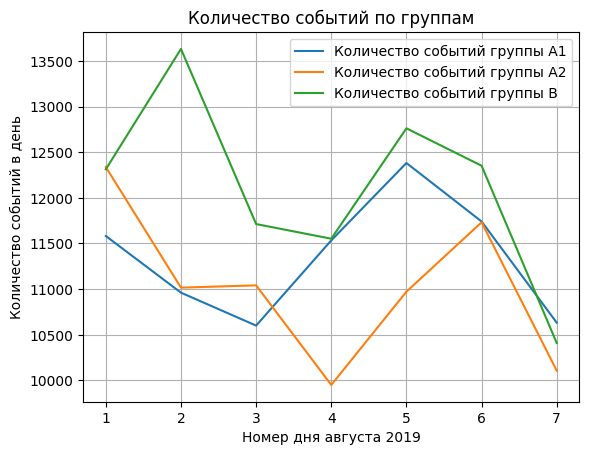

In [ ]:
plt.plot(group_date.index+1,group_date['events_a1'],label='Количество событий группы А1')
plt.plot(group_date.index+1,group_date['events_a2'], label='Количество событий группы А2')
plt.plot(group_date.index+1,group_date['events_b'], label='Количество событий группы В')
plt.legend()
plt.ylabel('Количество событий в день')
plt.xlabel('Номер дня августа 2019')
plt.ticklabel_format(style='plain')
plt.title('Количество событий по группам')
plt.grid()

Количетсво событий со временем по каждой группе хаотично имеет хаотичную динамику. Хотя некие общие моменты все же есть - начинают более активно контрольные группы и у всех 3 групп намечается минимальная точка в количестве событий 4 августа, после этого идет рост до 5-6 числа потом опять спад. Пока что видно что в среднем по количеству логов лидируте группа B, контрольные же группы пока догоняют.

**------------------------------------------------------------------------------------------------------------------------------------------------**

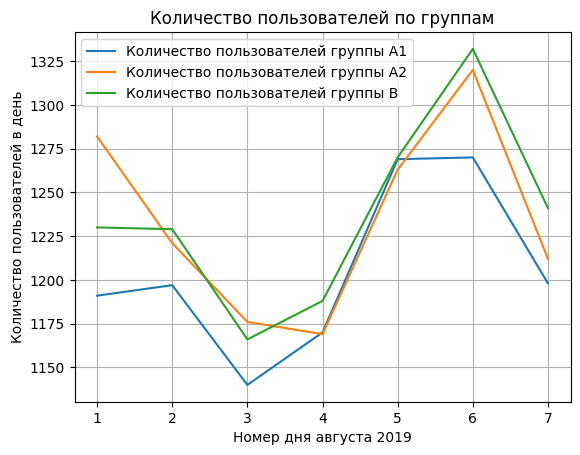

In [ ]:
plt.plot(group_date.index+1,group_date['users_a1'],label='Количество пользователей группы А1')
plt.plot(group_date.index+1,group_date['users_a2'], label='Количество пользователей группы А2')
plt.plot(group_date.index+1,group_date['users_b'], label='Количество пользователей группы В')
plt.legend()
plt.ylabel('Количество пользователей в день')
plt.xlabel('Номер дня августа 2019')
plt.ticklabel_format(style='plain')
plt.title('Количество пользователей по группам')
plt.grid()

Очень похожий анализ можно сделать и по текущему графику 3-4 числа низшая точка у всех трех групп, 5-6 пик числа пользователей. B в среднем выше контрольных групп.

**------------------------------------------------------------------------------------------------------------------------------------------------**

In [ ]:
group_date['users_b-a1']=(group_date['users_b']
                                 -group_date['users_a1'])
group_date['users_b-a2']=(group_date['users_b']
                                 -group_date['users_a2'])
group_date['users_a1-a2']=(group_date['users_a1']
                                 -group_date['users_a2'])

group_date['users_b/a1-1']=round((group_date['users_b']
                                    /group_date['users_a1']-1)*100,2)
group_date['users_b/a2-1']=round((group_date['users_b']
                                  /group_date['users_a2']-1)*100,2)
group_date['users_a1/a2-1']=round((group_date['users_a1']
                                    /group_date['users_a2']-1)*100,2)

group_date

,date,users_a1,events_a1,users_a2,events_a2,users_b,events_b,users_b-a1,users_b-a2,users_a1-a2,users_b/a1-1,users_b/a2-1,users_a1/a2-1
0,2019-08-01,1191,11581,1282,12336,1230,12312,39,-52,-91,3.27,-4.06,-7.10
1,2019-08-02,1197,10960,1221,11015,1229,13631,32,8,-24,2.67,0.66,-1.97
2,2019-08-03,1140,10599,1176,11040,1166,11712,26,-10,-36,2.28,-0.85,-3.06
3,2019-08-04,1170,11533,1169,9949,1188,11551,18,19,1,1.54,1.63,0.09
4,2019-08-05,1269,12381,1263,10971,1270,12761,1,7,6,0.08,0.55,0.48
5,2019-08-06,1270,11740,1320,11731,1332,12351,62,12,-50,4.88,0.91,-3.79
6,2019-08-07,1198,10631,1212,10105,1241,10408,43,29,-14,3.59,2.39,-1.16


In [ ]:
group_date['events_b-a1']=(group_date['events_b']
                                 -group_date['events_a1'])
group_date['events_b-a2']=(group_date['events_b']
                                 -group_date['events_a2'])
group_date['events_a1-a2']=(group_date['events_a1']
                                 -group_date['events_a2'])

group_date['events_b/a1-1']=round((group_date['events_b']
                                    /group_date['events_a1']-1)*100,2)
group_date['events_b/a2-1']=round((group_date['events_b']
                                  /group_date['events_a2']-1)*100,2)
group_date['events_a1/a2-1']=round((group_date['events_a1']
                                    /group_date['events_a2']-1)*100,2)

group_date.set_index('date').loc[:,'events_b-a1':'events_a1/a2-1']

,events_b-a1,events_b-a2,events_a1-a2,events_b/a1-1,events_b/a2-1,events_a1/a2-1
date,,,,,,
2019-08-01,731,-24,-755,6.31,-0.19,-6.12
2019-08-02,2671,2616,-55,24.37,23.75,-0.50
2019-08-03,1113,672,-441,10.50,6.09,-3.99
2019-08-04,18,1602,1584,0.16,16.10,15.92
2019-08-05,380,1790,1410,3.07,16.32,12.85
2019-08-06,611,620,9,5.20,5.29,0.08
2019-08-07,-223,303,526,-2.10,3.00,5.21


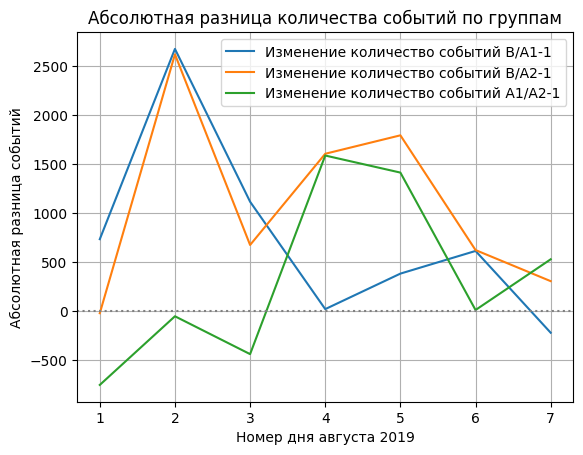

In [ ]:
plt.plot(group_date.index+1,group_date['events_b-a1'], label='Изменение количество событий B/A1-1')
plt.plot(group_date.index+1,group_date['events_b-a2'], label='Изменение количество событий B/A2-1')
plt.plot(group_date.index+1,group_date['events_a1-a2'], label='Изменение количество событий A1/A2-1')
plt.legend()

plt.ylabel('Абсолютная разница событий')
plt.xlabel('Номер дня августа 2019')
plt.ticklabel_format(style='plain')
plt.title('Абсолютная разница количества событий по группам')
plt.grid()
plt.axhline(y=0,linestyle=':', color='grey');

На графике абсолютной разницы количества событий видно, что B/A1 кроме 4 и 5 числа выше 0. А B/A2 ниже всего 1 день (5 числа), что может подтвердать гипотезу о том, что внедрение новых шрифтов хорошо отражается на активности пользователей. Разница в контрольных же группах 50 на 50 - половину времени группа A1 больше A2, а остальную половину наоборот.

**------------------------------------------------------------------------------------------------------------------------------------------------**

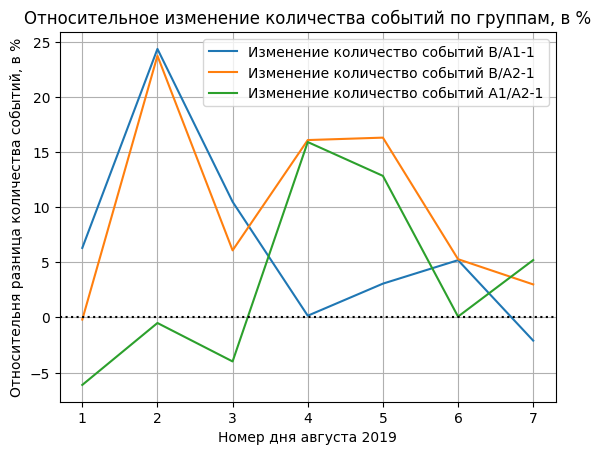

In [ ]:
plt.plot(group_date.index+1,group_date['events_b/a1-1'], label='Изменение количество событий B/A1-1')
plt.plot(group_date.index+1,group_date['events_b/a2-1'], label='Изменение количество событий B/A2-1')
plt.plot(group_date.index+1,group_date['events_a1/a2-1'], label='Изменение количество событий A1/A2-1')
plt.legend()
plt.ylabel('Относительня разница количества событий, в %')
plt.xlabel('Номер дня августа 2019')
plt.ticklabel_format(style='plain')
plt.title('Относительное изменение количества событий по группам, в %')
plt.grid()
plt.axhline(y=0,linestyle=':', color='black');

График относительного изменения ПОЛНОСТЬЮ подобен графику абсолютного изменения количества событий.

**------------------------------------------------------------------------------------------------------------------------------------------------**

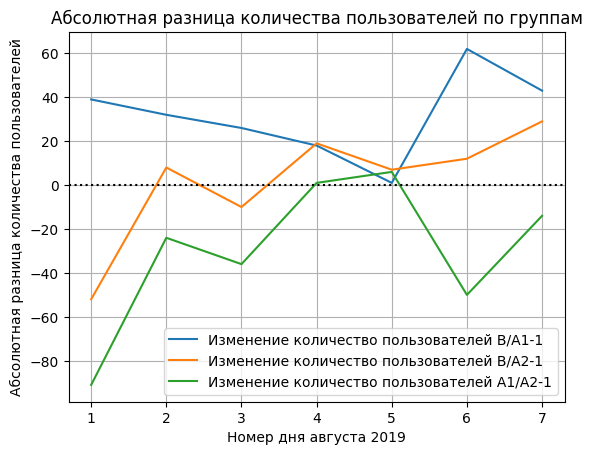

In [ ]:
plt.plot(group_date.index+1,group_date['users_b-a1'], label='Изменение количество пользователей B/A1-1')
plt.plot(group_date.index+1,group_date['users_b-a2'], label='Изменение количество пользователей B/A2-1')
plt.plot(group_date.index+1,group_date['users_a1-a2'], label='Изменение количество пользователей A1/A2-1')
plt.legend()
plt.ylabel('Абсолютная разница количества пользователей')
plt.xlabel('Номер дня августа 2019')
plt.ticklabel_format(style='plain')
plt.title('Абсолютная разница количества пользователей по группам')
plt.grid()
plt.axhline(y=0,linestyle=':', color='black');

Графике абсолютной разницы количества пользователей  говорит о том, что B/A1-1 все время выше 0. А B/A2-1 ниже 2 дня (1 и 3 числа), что может подтвердать гипотезу о том, что внедрение новых шрифтов хорошо отражается на активности пользователей. Разница в контрольных же группах такова A1/A2-1 всегда ниже нуля - в группе A2 количество пользователей всегда выше примерно на 20 пользователей - 2 процента.

**------------------------------------------------------------------------------------------------------------------------------------------------**

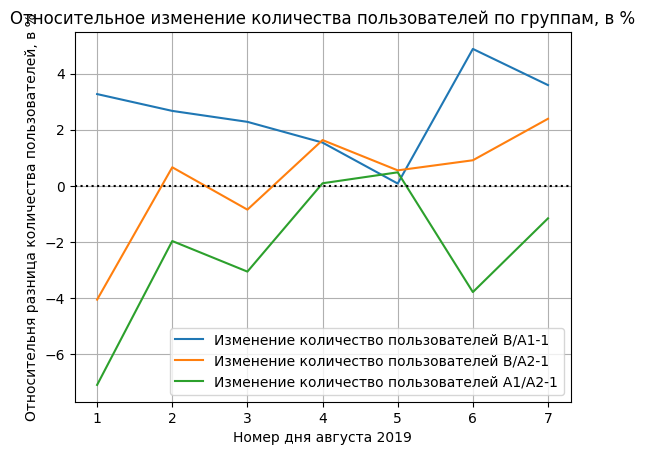

In [ ]:
plt.plot(group_date.index+1,group_date['users_b/a1-1'], label='Изменение количество пользователей B/A1-1')
plt.plot(group_date.index+1,group_date['users_b/a2-1'], label='Изменение количество пользователей B/A2-1')
plt.plot(group_date.index+1,group_date['users_a1/a2-1'], label='Изменение количество пользователей A1/A2-1')
plt.legend()
plt.ylabel('Относительня разница количества пользователей, в %')
plt.xlabel('Номер дня августа 2019')
plt.ticklabel_format(style='plain')
plt.title('Относительное изменение количества пользователей по группам, в %')
plt.grid()
plt.axhline(y=0,linestyle=':', color='black');

График относительного изменения ПОЛНОСТЬЮ подобен графику абсолютного изменения пользователей событий.

**------------------------------------------------------------------------------------------------------------------------------------------------**

In [ ]:
group_date_cum=group_date.loc[:,'date':'events_b'].set_index('date').cumsum(axis=0).reset_index()
group_date_cum

,date,users_a1,events_a1,users_a2,events_a2,users_b,events_b
0,2019-08-01,1191,11581,1282,12336,1230,12312
1,2019-08-02,2388,22541,2503,23351,2459,25943
2,2019-08-03,3528,33140,3679,34391,3625,37655
3,2019-08-04,4698,44673,4848,44340,4813,49206
4,2019-08-05,5967,57054,6111,55311,6083,61967
5,2019-08-06,7237,68794,7431,67042,7415,74318
6,2019-08-07,8435,79425,8643,77147,8656,84726


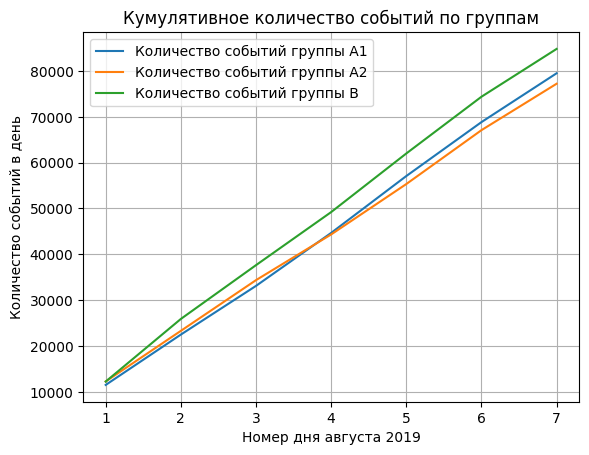

In [ ]:
plt.plot(group_date_cum.index+1,group_date_cum['events_a1'],label='Количество событий группы А1')
plt.plot(group_date_cum.index+1,group_date_cum['events_a2'], label='Количество событий группы А2')
plt.plot(group_date_cum.index+1,group_date_cum['events_b'], label='Количество событий группы В')
plt.legend()
plt.ylabel('Количество событий в день')
plt.xlabel('Номер дня августа 2019')
plt.ticklabel_format(style='plain')
plt.title('Кумулятивное количество событий по группам')
plt.grid();

Видно что B немного выше остальных. В контрольных группах А2 еще меньше выше А1.

**------------------------------------------------------------------------------------------------------------------------------------------------**

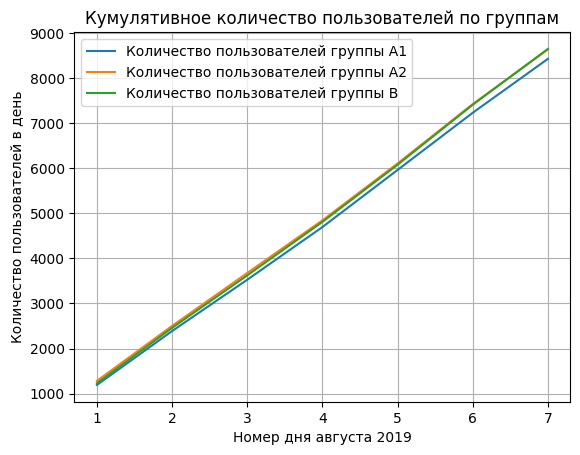

In [ ]:
plt.plot(group_date_cum.index+1,group_date_cum['users_a1'],label='Количество пользователей группы А1')
plt.plot(group_date_cum.index+1,group_date_cum['users_a2'], label='Количество пользователей группы А2')
plt.plot(group_date_cum.index+1,group_date_cum['users_b'], label='Количество пользователей группы В')
plt.legend()
plt.ylabel('Количество пользователей в день')
plt.xlabel('Номер дня августа 2019')
plt.ticklabel_format(style='plain')
plt.title('Кумулятивное количество пользователей по группам')
plt.grid();

Тут можно отметить что A1 немного отстаем от других групп.

**------------------------------------------------------------------------------------------------------------------------------------------------**

In [ ]:
group_date_cum['events_b-a1']=(group_date_cum['events_b']
                                 -group_date_cum['events_a1'])
group_date_cum['events_b-a2']=(group_date_cum['events_b']
                                 -group_date_cum['events_a2'])
group_date_cum['events_a1-a2']=(group_date_cum['events_a1']
                                 -group_date_cum['events_a2'])

group_date_cum['events_b/a1-1']=round((group_date_cum['events_b']
                                    /group_date_cum['events_a1']-1)*100,2)
group_date_cum['events_b/a2-1']=round((group_date_cum['events_b']
                                  /group_date_cum['events_a2']-1)*100,2)
group_date_cum['events_a1/a2-1']=round((group_date_cum['events_a1']
                                    /group_date_cum['events_a2']-1)*100,2)
group_date_cum.set_index('date').loc[:,'events_b-a1':'events_a1/a2-1']

,events_b-a1,events_b-a2,events_a1-a2,events_b/a1-1,events_b/a2-1,events_a1/a2-1
date,,,,,,
2019-08-01,731,-24,-755,6.31,-0.19,-6.12
2019-08-02,3402,2592,-810,15.09,11.10,-3.47
2019-08-03,4515,3264,-1251,13.62,9.49,-3.64
2019-08-04,4533,4866,333,10.15,10.97,0.75
2019-08-05,4913,6656,1743,8.61,12.03,3.15
2019-08-06,5524,7276,1752,8.03,10.85,2.61
2019-08-07,5301,7579,2278,6.67,9.82,2.95


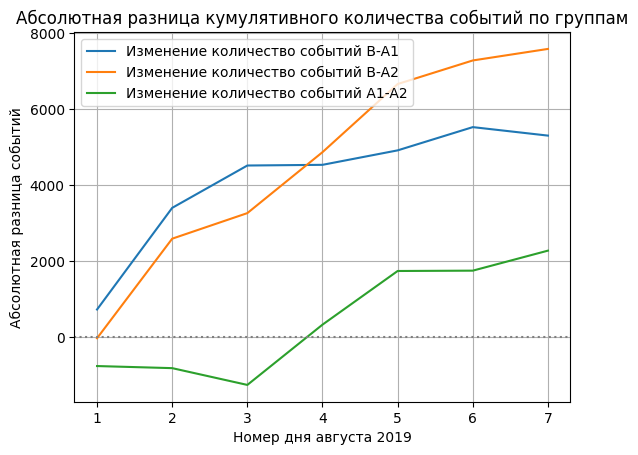

In [ ]:
plt.plot(group_date_cum.index+1,group_date_cum['events_b-a1'], label='Изменение количество событий B-A1')
plt.plot(group_date_cum.index+1,group_date_cum['events_b-a2'], label='Изменение количество событий B-A2')
plt.plot(group_date_cum.index+1,group_date_cum['events_a1-a2'], label='Изменение количество событий A1-A2')
plt.legend()
plt.ylabel('Абсолютная разница событий')
plt.xlabel('Номер дня августа 2019')
plt.ticklabel_format(style='plain')
plt.title('Абсолютная разница кумулятивного количества событий по группам')
plt.grid()
plt.axhline(y=0,linestyle=':', color='grey');

В абсолютной разницы кумулятивного количества событий B-A1 и B-A2 - больше нуля и разница растет. Что может быть подтверждением теории.

**------------------------------------------------------------------------------------------------------------------------------------------------**

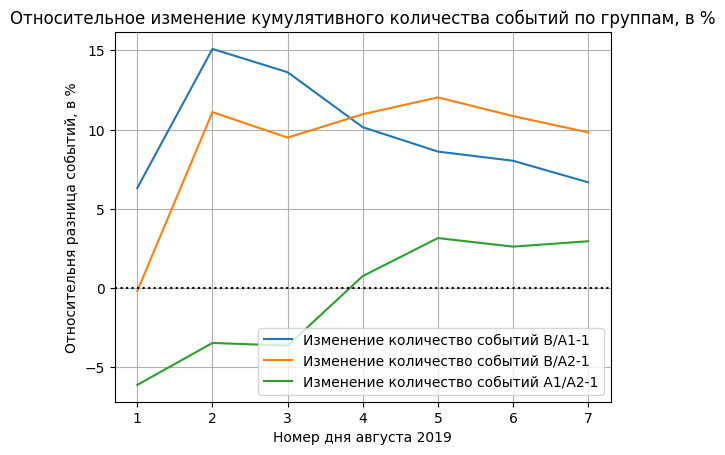

In [ ]:
plt.plot(group_date_cum.index+1,group_date_cum['events_b/a1-1'], label='Изменение количество событий B/A1-1')
plt.plot(group_date_cum.index+1,group_date_cum['events_b/a2-1'], label='Изменение количество событий B/A2-1')
plt.plot(group_date_cum.index+1,group_date_cum['events_a1/a2-1'], label='Изменение количество событий A1/A2-1')
plt.legend()
plt.ylabel('Относительня разница событий, в %')
plt.xlabel('Номер дня августа 2019')
plt.ticklabel_format(style='plain')
plt.title('Относительное изменение кумулятивного количества событий по группам, в %')
plt.grid()
plt.axhline(y=0,linestyle=':', color='black');

График относительного изменения немного отличается по тренду, но имеет сходство с графиком абсолютной разницы кумулятивного количества событий.

**------------------------------------------------------------------------------------------------------------------------------------------------**

In [ ]:
group_date_cum['users_b-a1']=(group_date_cum['users_b']
                                 -group_date_cum['users_a1'])
group_date_cum['users_b-a2']=(group_date_cum['users_b']
                                 -group_date_cum['users_a2'])
group_date_cum['users_a1-a2']=(group_date_cum['users_a1']
                                 -group_date_cum['users_a2'])

group_date_cum['users_b/a1-1']=round((group_date_cum['users_b']
                                    /group_date_cum['users_a1']-1)*100,2)
group_date_cum['users_b/a2-1']=round((group_date_cum['users_b']
                                  /group_date_cum['users_a2']-1)*100,2)
group_date_cum['users_a1/a2-1']=round((group_date_cum['users_a1']
                                    /group_date_cum['users_a2']-1)*100,2)
group_date_cum.set_index('date').loc[:,'users_b-a1':'users_a1/a2-1']

,users_b-a1,users_b-a2,users_a1-a2,users_b/a1-1,users_b/a2-1,users_a1/a2-1
date,,,,,,
2019-08-01,39,-52,-91,3.27,-4.06,-7.10
2019-08-02,71,-44,-115,2.97,-1.76,-4.59
2019-08-03,97,-54,-151,2.75,-1.47,-4.10
2019-08-04,115,-35,-150,2.45,-0.72,-3.09
2019-08-05,116,-28,-144,1.94,-0.46,-2.36
2019-08-06,178,-16,-194,2.46,-0.22,-2.61
2019-08-07,221,13,-208,2.62,0.15,-2.41


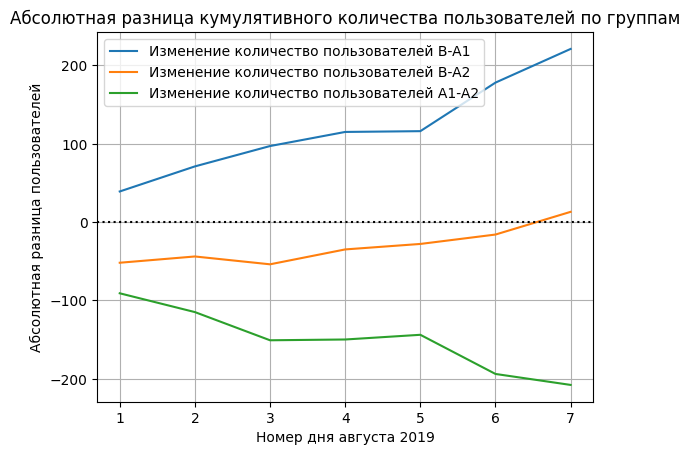

In [ ]:
plt.plot(group_date_cum.index+1,group_date_cum['users_b-a1'], label='Изменение количество пользователей B-A1')
plt.plot(group_date_cum.index+1,group_date_cum['users_b-a2'], label='Изменение количество пользователей B-A2')
plt.plot(group_date_cum.index+1,group_date_cum['users_a1-a2'], label='Изменение количество пользователей A1-A2')
plt.legend()
plt.ylabel('Абсолютная разница пользователей')
plt.xlabel('Номер дня августа 2019')
plt.ticklabel_format(style='plain')
plt.title('Абсолютная разница кумулятивного количества пользователей по группам')
plt.grid()
plt.axhline(y=0,linestyle=':', color='black');

Тренд абсолютной разницы кумулятивного количества пользователей: B-A1 больше нуля на всем промежутке. Остальные графики ниже нуля.

**------------------------------------------------------------------------------------------------------------------------------------------------**

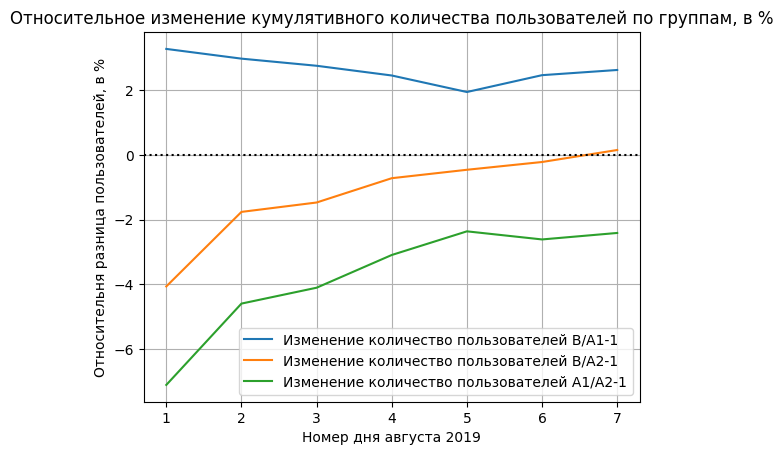

In [ ]:
plt.plot(group_date_cum.index+1,group_date_cum['users_b/a1-1'], label='Изменение количество пользователей B/A1-1')
plt.plot(group_date_cum.index+1,group_date_cum['users_b/a2-1'], label='Изменение количество пользователей B/A2-1')
plt.plot(group_date_cum.index+1,group_date_cum['users_a1/a2-1'], label='Изменение количество пользователей A1/A2-1')
plt.legend()
plt.ylabel('Относительня разница пользователей, в %')
plt.xlabel('Номер дня августа 2019')
plt.ticklabel_format(style='plain')
plt.title('Относительное изменение кумулятивного количества пользователей по группам, в %')
plt.grid()
plt.axhline(y=0,linestyle=':', color='black');

На графике кумулятиных значений количества видно, что B/A1-1 стабильно выше нуля, а остальные ниже нуля. К 7 числу B/A2-1 стремится превысить 0.

**Вывод:**

**Число пользователей и их процент от общего  количество:**

* A1 - 2 484 - 32.97%;

* A2 - 2 513 - 33.36%;

* B - 2 537 - 33.67%;

**p-value при сравнении двух контрольных групп = 0,11 - нет основания считать доли разными - разница не является статзначимой.**

**Самым популярным событием является MainScreenAppear.
Число пользователей это событие и их доля от всех событий в группе:**

* A1 - 2 450 - 0.986;

* A2 - 2 476 - 0.985;

**p-value = 0,92 - отличие в группах не является статитстически достоверным.**

**При сравнении проведении z-тестов c a=0,1, на группах A1 и А2, p-value было равно:**

* OffersScreenAppear -0.28;

* CartScreenAppear - 0.26;

* PaymentScreenSuccessful  0.136;

* Tutorial - 0.781;

**Отличия в этих группах нельзя признать статзначимыми. Это значит что разбиение на группы работает корректно, повышается достоверность эксперимента.**

**При сравнении проведении z-тестов c a=0,1, на группах A1 и B, p-value было равно:**

* MainScreenAppear - 0.244;

* OffersScreenAppear - 0.218;

* CartScreenAppear - 0.083;

* PaymentScreenSuccessful  0.22;

* Tutorial - 0.965;

**Отличия в этих группах нельзя признать статзначимыми.**

**При сравнении проведении z-тестов c a=0,1, на группах A2 и B, p-value было равно:**

* MainScreenAppear - 0.455;

* OffersScreenAppear - 0.885;

* CartScreenAppear - 0.54;

* PaymentScreenSuccessful  0.78;

* Tutorial - 0.814;

**Отличия в этих группах также нельзя признать статзначимыми.**

**При сравнении проведении z-тестов c a=0,1, на группах united и B, p-value было равно:**

* MainScreenAppear - 0.262;

* OffersScreenAppear - 0.428;

* CartScreenAppear - 0.176;

* PaymentScreenSuccessful  0.59;

* Tutorial - 0.911;

**Отличия в этих группах также нельзя признать статзначимыми.**

**Ни одну из нулевых гипотез о схожести 2 долей не удалось отвергнуть.**

**Требуемвый уровень значимости зависит от поправки Бонферрони - bonferroni_alpha = alpha / 20 (количество гипотез) - bonferroni_alpha = 0,1, но выводы не изменились - ни одна из нулевых гипотез так не была отвергнута.**

**Как видно между 3 группами даже если рассмтаривать отдельно по событиям нет статзначимых различий. Относительная разницы между количеством человек у событий на сумму человек в группах тоже сильно не отличается. Максимальное значение относительных различий у PaymentScreenSuccessful при сравнении групп A1 и A2 (3,6% в пользу А1).**

**Также был проведен графический сравнительный анализ показателей между группами, где на многих графиках, но что самое главное на графиках кумулятивных метрик группа В лидировала. Возможно шрифты при более большом сроке принесут свои плоды.**

**------------------------------------------------------------------------------------------------------------------------------------------------**

## Общий вывод:

Во время предобработки данных были удалены 413 дубликатов. Кроме этого был удален данные за неделю до августа, так как там почти не было данных - новый период с 1 по 7 августа 2019. В логах есть следующие возможные типы событий: Tutorial, MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful. То есть 5 типов событий.

Количество пользователей, совершивших событий и их доля от числа всех событий:

* MainScreenAppear - 7 419 - 98%;

* OffersScreenAppear - 4 539 - 61%;

* CartScreenAppear - 3 734 - 50%;

* PaymentScreenSuccessful - 3 53 - 47%;

* Tutorial - 840 - 11%;

* Всего: 7 534 - 100%.

События происходят в следующем порядке: Main Screen Appear ---> Offers Screen Appear ---> Cart Screen Appear ---> Payment Screen Successful. Из цепочки выбивается Tutorial с ним либо есть проблемы либо он просто не нужен при анализе.

При переходе с MainScreenAppear на OffersScreenAppear конверсия = 0.61; при переходе с шага OffersScreenAppear на шаг CartScreenAppear общая конверсия = 0,5 , а шаговая конверсия = 0,81; с CartScreenAppear на PaymentScreenSuccessful - общая конверсия = 0.48, шаговая = 0.95. Больше всего теряется на 1 шаге - нужно обратить на это внимание. С начала взаимодействия до оплаты доходит 52%.

Относительная разницы между количеством человек у событий на сумму человек в группах тоже сильно не отличается. Максимальное значение относительных различий у PaymentScreenSuccessful при сравнении групп A1 и A2 (3,6% в пользу А1).

При z-тестах ни одна 0 гипотеза, которая гласит что между количеством пользователей нет статистической разницы не была отвергнута, что означает что нет основания считать доли разными

Требуемвый уровень значимости зависит от поправки Бонферрони - bonferroni_alpha = alpha / 20 (количество гипотез) - bonferroni_alpha = 0,1, но выводы не изменились - ни одна из нулевых гипотез так не была отвергнута.

**Из результатов анализа A/A/B-эксперимента следует, что изменение шрифта в приложении не повлияло на поведение пользователей.**